In [48]:
from keras.models import Model
from keras.optimizers import SGD
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers.pooling import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras import backend as K
from sklearn.utils import class_weight
from collections import defaultdict
import numpy as np
import os

In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [7]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/Images/training/',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/Images/test/',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary')

Found 35850 images belonging to 2 classes.
Found 15367 images belonging to 2 classes.


In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [9]:
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

In [10]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [11]:
x = base_model.output
x = Flatten()(x)
x = Dense(256)(x)
x = Dense(1)(x)
x = Activation('sigmoid')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
            loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(
        train_generator,
        steps_per_epoch=35850 // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=15367 // batch_size)
model.save_weights('vgg16_notdog.h5')

Epoch 1/5
2240/2240 [==============================] - 1674s - loss: 0.2229 - acc: 0.9084 - val_loss: 0.1858 - val_acc: 0.9258
Epoch 2/5
2240/2240 [==============================] - 1667s - loss: 0.1602 - acc: 0.9365 - val_loss: 0.1645 - val_acc: 0.9369
Epoch 4/5
2240/2240 [==============================] - 1668s - loss: 0.1520 - acc: 0.9408 - val_loss: 0.2060 - val_acc: 0.9118
Epoch 5/5
2240/2240 [==============================] - 1667s - loss: 0.1425 - acc: 0.9435 - val_loss: 0.1613 - val_acc: 0.9353


In [ ]:
model.summary()

In [160]:
batch_size = 10

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/Images/training/',  # this is the target directory
        target_size=(299, 299),  # all images will be resized to 224x224
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/Images/test/',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical')

Found 29782 images belonging to 115 classes.
Found 20501 images belonging to 115 classes.


In [8]:
base_model = Xception(include_top=False, input_shape=(299, 299, 3))

In [26]:
dict(validation_generator.class_indices).values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113])

In [5]:
class_weight = class_weight.compute_class_weight('balanced', np.unique(train_generator.classes),train_generator.classes)

In [6]:
class_weights = dict(zip(dict(validation_generator.class_indices).values(), class_weight))

In [30]:
class_weights

{0: 2.6036842105263158,
 1: 2.6036842105263158,
 2: 2.6036842105263158,
 3: 2.6036842105263158,
 4: 2.6036842105263158,
 5: 2.6036842105263158,
 6: 2.6036842105263158,
 7: 2.6036842105263158,
 8: 2.6036842105263158,
 9: 2.6036842105263158,
 10: 2.6036842105263158,
 11: 2.6036842105263158,
 12: 2.6036842105263158,
 13: 2.6036842105263158,
 14: 2.6036842105263158,
 15: 2.6036842105263158,
 16: 2.6036842105263158,
 17: 2.6036842105263158,
 18: 2.6036842105263158,
 19: 2.6036842105263158,
 20: 2.6036842105263158,
 21: 2.6036842105263158,
 22: 2.6036842105263158,
 23: 2.6036842105263158,
 24: 2.6036842105263158,
 25: 2.6036842105263158,
 26: 2.6036842105263158,
 27: 2.6036842105263158,
 28: 2.6036842105263158,
 29: 2.6036842105263158,
 30: 2.6036842105263158,
 31: 2.6036842105263158,
 32: 2.6036842105263158,
 33: 2.6036842105263158,
 34: 2.6036842105263158,
 35: 2.6036842105263158,
 36: 2.6036842105263158,
 37: 2.6036842105263158,
 38: 2.6036842105263158,
 39: 2.6036842105263158,
 40: 2.603

In [10]:
# Freeze convolutional layers
for layer in base_model.layers[:-3]:
    layer.trainable = False

In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000)(x)
x = Dropout(0.5, name="dropout")(x)
x = Dense(114, name="categories_dense")(x)
x = Activation('softmax')(x)

In [13]:
model = Model(inputs=base_model.input, outputs=x)
model.load_weights('xception_breeds_weighted.h5', by_name=True)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
            loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [40]:
model.fit_generator(
        train_generator,
        steps_per_epoch=35850 // batch_size,
        epochs=5,
        verbose=2,
        validation_data=validation_generator,
        validation_steps=15367 // batch_size)
model.save_weights('xception_breeds_weighted.h5')

Epoch 1/5
3585/3585 [==============================] - 2169s - loss: 0.3513 - acc: 0.8948 - val_loss: 0.2114 - val_acc: 0.9691
Epoch 2/5
3585/3585 [==============================] - 2168s - loss: 0.1531 - acc: 0.9752 - val_loss: 0.1248 - val_acc: 0.9811
Epoch 3/5
3585/3585 [==============================] - 2168s - loss: 0.1063 - acc: 0.9812 - val_loss: 0.0923 - val_acc: 0.9851
Epoch 4/5
3585/3585 [==============================] - 2168s - loss: 0.0830 - acc: 0.9833 - val_loss: 0.0751 - val_acc: 0.9874
Epoch 5/5
3585/3585 [==============================] - 2168s - loss: 0.0731 - acc: 0.9845 - val_loss: 0.0624 - val_acc: 0.9890


In [20]:
full_model = Xception(weights='imagenet', include_top=True, input_shape=(299, 299, 3))

90923008/91884032 [============================>.] - ETA: 0s

In [21]:
full_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_2[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

## Initial multiclass classifier (114 dense layer), just predicting "not dog", ignoring breeds

Epoch 1/5
3274/3274 [==============================] - 2196s - loss: 4.2286 - acc: 0.6370 - val_loss: 4.2056 - val_acc: 0.5291

Epoch 2/5
3274/3274 [==============================] - 2195s - loss: 3.8577 - acc: 0.6550 - val_loss: 3.8597 - val_acc: 0.5292

Epoch 3/5
3274/3274 [==============================] - 2195s - loss: 3.2350 - acc: 0.6548 - val_loss: 3.3696 - val_acc: 0.5292

Epoch 4/5
3274/3274 [==============================] - 2195s - loss: 2.5512 - acc: 0.6549 - val_loss: 2.9330 - val_acc: 0.5293

Epoch 5/5
3274/3274 [==============================] - 2196s - loss: 2.1126 - acc: 0.6551 - val_loss: 2.5876 - val_acc: 0.5288

(1000 dense layer -> 114 dense layer)

Epoch 1/5
3274/3274 [==============================] - 2139s - loss: 3.9772 - acc: 0.6458 - val_loss: 3.6064 - val_acc: 0.5291

Epoch 2/5
3274/3274 [==============================] - 2136s - loss: 2.2391 - acc: 0.6550 - val_loss: 2.3954 - val_acc: 0.5289

Epoch 3/5
3274/3274 [==============================] - 2134s - loss: 1.7989 - acc: 0.6550 - val_loss: 2.0715 - val_acc: 0.5290

Epoch 4/5
3274/3274 [==============================] - 2134s - loss: 1.6013 - acc: 0.6549 - val_loss: 1.7951 - val_acc: 0.5294

Epoch 5/5
3274/3274 [==============================] - 2136s - loss: 1.4372 - acc: 0.6549 - val_loss: 1.5885 - val_acc: 0.5293

## class weighted results
Epoch 1/2
3561/3561 [==============================] - 2397s - loss: 4.5732 - acc: 0.0482 - val_loss: 4.4836 - val_acc: 0.2049

Epoch 2/2
3561/3561 [==============================] - 2394s - loss: 4.2764 - acc: 0.3650 - val_loss: 4.1095 - val_acc: 0.6115


### Test model results trained in xception_dogbreeds.py

In [4]:
base_model = Xception(include_top=False, input_shape=(299, 299, 3))

In [6]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1000)(x)
x = Dense(115, name="categories_dense2")(x)
x = Activation('softmax')(x)

In [7]:
model = Model(inputs=base_model.input, outputs=x)

In [8]:
model.load_weights('xception_breeds_wgt_reg_conv5.h5', by_name=True)

In [9]:
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
            loss='categorical_crossentropy', metrics=['accuracy'])

In [152]:
img = image.load_img('./data/Images/test/n02113978-Mexican_hairless/n02113978_2726.jpg', target_size=(299, 299))

In [153]:
x = image.img_to_array(img)

In [154]:
x = np.expand_dims(x, axis=0)
x = x / 255

In [159]:
x

array([[[[ 0.97647059,  0.89411765,  0.78039217],
         [ 0.97647059,  0.89411765,  0.78039217],
         [ 0.97647059,  0.89411765,  0.78039217],
         ..., 
         [ 0.82352942,  0.75294119,  0.65882355],
         [ 0.82352942,  0.75294119,  0.65882355],
         [ 0.81568629,  0.75686276,  0.67450982]],

        [[ 0.97647059,  0.89411765,  0.78039217],
         [ 0.97647059,  0.89411765,  0.78039217],
         [ 0.97647059,  0.89411765,  0.78039217],
         ..., 
         [ 0.82352942,  0.75294119,  0.65882355],
         [ 0.82352942,  0.75294119,  0.65882355],
         [ 0.81568629,  0.75686276,  0.67450982]],

        [[ 0.97647059,  0.89411765,  0.78039217],
         [ 0.98039216,  0.89803922,  0.78431374],
         [ 0.98039216,  0.89803922,  0.78431374],
         ..., 
         [ 0.82745099,  0.75686276,  0.66274512],
         [ 0.82745099,  0.75686276,  0.66274512],
         [ 0.81568629,  0.75686276,  0.67450982]],

        ..., 
        [[ 0.09019608,  0.08627451,

In [155]:
pred = model.predict(x)

In [156]:
pred

array([[ 0.01222456,  0.00684785,  0.00609357,  0.00795943,  0.01669548,
         0.00452985,  0.0068268 ,  0.00471877,  0.01236691,  0.00945483,
         0.00966364,  0.00855907,  0.00697188,  0.00427885,  0.01233376,
         0.00708083,  0.00594953,  0.0193153 ,  0.00763925,  0.00650031,
         0.01613616,  0.01874757,  0.01291719,  0.01219758,  0.00304813,
         0.00485176,  0.01354216,  0.02200034,  0.00377239,  0.00699306,
         0.00503643,  0.00721296,  0.01001197,  0.00416043,  0.00526523,
         0.00408465,  0.0065349 ,  0.02015107,  0.00637622,  0.01131909,
         0.00681481,  0.00555064,  0.01033565,  0.00977571,  0.00599983,
         0.00790501,  0.00534145,  0.00826216,  0.01192865,  0.010133  ,
         0.00685717,  0.01126021,  0.01708028,  0.01894017,  0.00473224,
         0.01209072,  0.00416408,  0.0128312 ,  0.01571565,  0.01345249,
         0.01352553,  0.00444354,  0.00314646,  0.00655013,  0.00286633,
         0.00617009,  0.0027627 ,  0.00226009,  0.0

In [157]:
pred.argmax(axis=-1)

array([27])

In [151]:
validation_generator.class_indices

{'n02085620-Chihuahua': 0,
 'n02085782-Japanese_spaniel': 1,
 'n02085936-Maltese_dog': 2,
 'n02086079-Pekinese': 3,
 'n02086240-Shih-Tzu': 4,
 'n02086646-Blenheim_spaniel': 5,
 'n02086910-papillon': 6,
 'n02087046-toy_terrier': 7,
 'n02087394-Rhodesian_ridgeback': 8,
 'n02088094-Afghan_hound': 9,
 'n02088238-basset': 10,
 'n02088364-beagle': 11,
 'n02088466-bloodhound': 12,
 'n02088632-bluetick': 13,
 'n02089078-black-and-tan_coonhound': 14,
 'n02089867-Walker_hound': 15,
 'n02089973-English_foxhound': 16,
 'n02090379-redbone': 17,
 'n02090622-borzoi': 18,
 'n02090721-Irish_wolfhound': 19,
 'n02091032-Italian_greyhound': 20,
 'n02091134-whippet': 21,
 'n02091244-Ibizan_hound': 22,
 'n02091467-Norwegian_elkhound': 23,
 'n02091635-otterhound': 24,
 'n02091831-Saluki': 25,
 'n02092002-Scottish_deerhound': 26,
 'n02092339-Weimaraner': 27,
 'n02093256-Staffordshire_bullterrier': 28,
 'n02093428-American_Staffordshire_terrier': 29,
 'n02093647-Bedlington_terrier': 30,
 'n02093754-Border_terr

In [158]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [2]:
model = load_model('xbreeds_model.h5')

In [6]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, 149, 149, 32)  128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, 149, 149, 32)  0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [59]:
img = image.load_img('./data/Images/test/n02113978-Mexican_hairless/n02113978_131.jpg', target_size=(299, 299))

In [60]:
x = image.img_to_array(img)

In [61]:
x = np.expand_dims(x, axis=0)

In [62]:
x = preprocess_input(x)

In [63]:
pred = model.predict(x)

In [64]:
pred.argmax(axis=-1)

array([113])

In [3]:
breeds = np.load('breed_indices.npy').tolist()

In [4]:
directory = './data/Images/test/'

TypeError: 'dict_keys' object does not support indexing

In [5]:
class_preds = defaultdict(list)
for breed in breeds.keys():
    if breed == 'not_dog':
        continue
    breed_dir = os.path.join(directory, breed)
    breed_images = os.listdir(breed_dir)
    for img in breed_images:
        img = image.load_img(os.path.join(breed_dir, img), target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        pred = model.predict(x)
        class_pred.argmax(axis=-1):
             class_acc[breed] += 1
                
    class_acc[breed] /= len(breed_images)
    

In [6]:
class_acc

defaultdict(int,
            {'n02085620-Chihuahua': 0.19230769230769232,
             'n02085782-Japanese_spaniel': 0.6941176470588235,
             'n02085936-Maltese_dog': 0.7039473684210527,
             'n02086079-Pekinese': 0.4489795918367347,
             'n02086240-Shih-Tzu': 0.14912280701754385,
             'n02086646-Blenheim_spaniel': 0.4772727272727273,
             'n02086910-papillon': 0.6979166666666666,
             'n02087046-toy_terrier': 0.25,
             'n02087394-Rhodesian_ridgeback': 0.18055555555555555,
             'n02088094-Afghan_hound': 0.7985611510791367,
             'n02088238-basset': 0.3466666666666667,
             'n02088364-beagle': 0.4105263157894737,
             'n02088466-bloodhound': 0.3563218390804598,
             'n02088632-bluetick': 0.04225352112676056,
             'n02089078-black-and-tan_coonhound': 0.06779661016949153,
             'n02089867-Walker_hound': 0.33962264150943394,
             'n02089973-English_foxhound': 0.42105263157

In [108]:
count/len(os.listdir(directory))

0.4727272727272727

In [7]:
np.save('breed_acc.npy', class_acc)

In [86]:
breeds = np.load('breed_indices.npy').tolist()

In [11]:
import matplotlib.pyplot as plt

In [12]:
%matplotlib inline

<Container object of 114 artists>

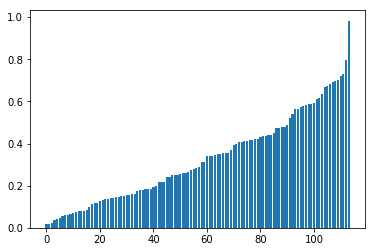

In [25]:
plt.bar(np.arange(len(accuracies)), sorted(accuracies))

In [32]:
y = [np.array([3, 5, 6])]

In [34]:
y.append(np.array([3, 6, 6]))

In [35]:
y

[array([3, 5, 6]), array([3, 6, 6])]

In [87]:
first_dense_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[-3].output])

In [88]:
second_dense_output = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.layers[-2].output])

In [90]:
breed_first_dense = defaultdict(list)
breed_second_dense = defaultdict(list)
for breed in breeds.keys():
    breed_dir = os.path.join(directory, breed)
    breed_images = os.listdir(breed_dir)
    for img in breed_images:
        img = image.load_img(os.path.join(breed_dir, img), target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        breed_first_dense[breed].append(list(first_dense_output([x, 0])))
        breed_second_dense[breed].append(list(second_dense_output([x, 0])))
                

In [96]:
np.save('test_second_layer.npy', breed_second_dense)

In [97]:
np.save('test_first_layer.npy', breed_first_dense)

In [130]:
second_dense_avg = dict()
for breed, vectors in breed_second_dense.items():
    vector_sum = np.zeros_like(vectors[0][0][0])
    for vector in vectors:
        vector_sum += vector[0][0]
    second_dense_avg[breed] = vector_sum/len(vectors)

In [131]:
second_dense_avg['n02110063-malamute']

array([ 0.33011729,  1.30627155, -0.06499024,  0.35378909, -0.4241001 ,
       -0.51912665,  1.38026488, -0.09033717, -1.00918996, -0.99526066,
       -1.24197304,  0.06910338, -1.65910769,  0.0551159 , -1.9337014 ,
       -0.5928508 , -0.80293477, -1.09146953,  2.15480733, -0.49237236,
       -1.20351481, -0.62583011, -0.34841684,  3.81540275, -1.41887963,
        1.35484719, -1.39254737,  0.04605744, -1.0911957 , -0.07586011,
        0.56740844, -1.60294628, -0.37931722, -0.93318176, -0.18422531,
       -0.23212184, -1.00265193, -0.39912891,  0.29542452, -1.05056345,
       -0.04772978, -1.77292693, -2.10403132, -0.66768897, -0.51567882,
       -0.24218544, -0.866799  , -0.62420356, -1.18627107, -0.2594147 ,
       -0.98190945, -1.54377079,  0.74595588, -0.22448906, -1.27570057,
       -0.8279379 ,  0.31278726,  0.17571101,  0.51871473, -0.14146376,
       -0.13703248,  0.66723645, -0.52700347, -1.99188364,  0.46581176,
        0.6775437 ,  0.29330438, -1.42271781, -1.29297483, -0.45

In [139]:
second_dense_max = dict()
for breed, vectors in breed_second_dense.items():
    vector_max = np.zeros_like(vectors[0][0][0])
    vector_max -= 100
    for vector in vectors:
        vector_max = np.maximum(vector[0][0], vector_max)
    second_dense_max[breed] = vector_max

In [142]:
np.save('breed_max_vec.npy', second_dense_max)

In [144]:
second_dense_max['n02108000-EntleBucher'].argmax()

89